In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_validate
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import timedelta
from datetime import datetime
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.stats as stats
import xgboost as xgb
import requests as r
import pandas as pd
import seaborn as s
import numpy as np
import googlemaps
import postgres
import holidays
import config
import json
import math
import gc

# enable automatic garbage collection
gc.enable()

ie_holidays = holidays.Ireland()

import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Importing Data

### Stop Distances

In [3]:
stop_distances = pd.read_csv("stored_queries/distancedata.csv", header=None)
stop_distances.columns = ['stopid','previous_stopid','distance']
stop_distances.head()

,stopid,previous_stopid,distance
0,1636,1635,397
1,1338,1337,151
2,837,836,137
3,2740,7177,481
4,1201,4385,324


### Stops

In [4]:
stops = pd.read_csv("stop_information.csv")
cols = list(stops.columns)
cols[0] = 'ix'
stops.columns = cols
stops.drop(columns=cols[0], inplace=True)

### weather Data Preprocessing

In [5]:
weather = pd.read_csv("stored_queries/weather.csv")
weather.icon = weather.icon.astype('category')
weather.weatherdayofservice = pd.to_datetime(weather.weatherdayofservice)

### Leavetimes Data Preprocessing

In [5]:
data = pd.read_csv("stored_queries/combined.csv")
data.columns = ['dayofservice','tripid','lineid','direction','progrnumber','stopid','plannedDEP','plannedARR','actualDEP','actualARR','routeid']
gc.collect()

data.drop(columns=['routeid','plannedDEP','plannedARR','actualDEP'], inplace=True)
data.drop_duplicates()
gc.collect()

# data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])
gc.collect()

data.sort_values(by=['dayofservice','lineid','tripid','direction','progrnumber'], inplace=True)
gc.collect()

data.drop(columns=['lineid'], inplace=True)

# data.to_csv("stored_queries/combinedsorted.csv", index=False, chunksize=500000)

# del data
# gc.collect()

In [6]:
data.to_csv("stored_queries/combinedsorted.csv", index=False, chunksize=500000)

del data
gc.collect()

21

In [7]:
data = pd.read_csv("stored_queries/combinedsorted.csv")
data.head()

,dayofservice,tripid,direction,progrnumber,stopid,actualARR
0,2018-01-01,5956265,1,1,226,36048
1,2018-01-01,5956265,1,2,228,36075
2,2018-01-01,5956265,1,3,229,36091
3,2018-01-01,5956265,1,4,227,36125
4,2018-01-01,5956265,1,5,230,36183


In [8]:
data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])

**Remove Stops which are no longer in service**

In [10]:
# ==================== REMOVE INACTIVE STOPS ====================== #
active_stopids = stops.stopid.values

# remove all inactive stops from the dataset. -> additional models that arent needed. 
data = data[data.stopid.isin(active_stopids)]

**Make Arrays for previous stops etc..**

In [12]:
# previous stopid
previousstops =  list(data.stopid)
previousstops = np.array(previousstops[:-1]).astype(int)

In [13]:
# progrnumber of previous stopid
previousstops_progrnumber = list(data.progrnumber)
previousstops_progrnumber = np.array(previousstops_progrnumber[:-1]).astype(int)

In [14]:
# Actual arrival time of previous stopid
previousstops_actualARR = list(data.actualARR)
previousstops_actualARR = np.array(previousstops_actualARR[:-1])

In [15]:
# Delete the first row of the dataframe to shift the progrnumbers by one. 
data = data.iloc[1:]

In [16]:
data['previous_stopid'] = previousstops
data['previous_stopARR'] = previousstops_actualARR
data['previous_progrnumber'] = previousstops_progrnumber

In [18]:
data = data[data.progrnumber != 1]
data.dropna(inplace=True);

In [19]:
# recast type of integer cols from float to int. 
data.previous_stopid = data.previous_stopid.astype(int)
data.previous_progrnumber = data.previous_progrnumber.astype(int)

In [20]:
# make progrnumber difference column and then drop anything thats not exactly 1, removes data which skips stops. 
data['progrnumber_difference'] = data.progrnumber - data.previous_progrnumber

# remove non-consecutive stop pairs.
data = data[data.progrnumber_difference==1]

In [21]:
data = data[['dayofservice', 'tripid','stopid', 'previous_stopid', 'actualARR', 'previous_stopARR']]

In [22]:
data.head()

,dayofservice,tripid,stopid,previous_stopid,actualARR,previous_stopARR
1,2018-01-01,5956265,228,226,36075,36048
2,2018-01-01,5956265,229,228,36091,36075
3,2018-01-01,5956265,227,229,36125,36091
4,2018-01-01,5956265,230,227,36183,36125
5,2018-01-01,5956265,231,230,36254,36183


In [23]:
data.to_csv("stored_queries/combinedfinal.csv", index=False, chunksize=500000)

In [24]:
data.dtypes

dayofservice        datetime64[ns]
tripid                       int64
stopid                       int64
previous_stopid              int64
actualARR                    int64
previous_stopARR             int64
dtype: object

## import ready to go leavetimes table

In [6]:
data = pd.read_csv("stored_queries/combinedfinal.csv")

In [ ]:
data.dayofservice = pd.to_datetime(data.dayofservice.loc[:])

In [ ]:
data.dtypes
data.head()

## Separating stop_pairs

In [ ]:
stop_pairs = data[['stopid','previous_stopid']].drop_duplicates()

print("There are %d unique pairs of stops in stop distances" % (stop_pairs.count()[0]))

## Loop through stop_pairs

In [ ]:
no_stops = stop_pairs.count()[0]
print("There are %d models to train." % no_stops)

## Model Training 

In [ ]:
def set_season(x):
    winter = [11,12,1]
    autumn = [10,9,8]
    spring = [4,3,2]

    if x in winter:
        return 'Winter'
    elif x in autumn:
        return 'Autumn'
    elif x in spring:
        return 'Spring'
    else:
        return 'Summer'

In [ ]:
target     = ['travel_time']

predictors = ['temperature','humidity', 'windSpeed', 'rain', 'hour', 'holiday', 'weekend',
              'month','season_Winter','season_Autumn','season_Summer','season_Spring',
              'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
              'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind']

In [88]:
models = dict()
emptys = []
metric = dict()
Error_routes = []


# Model Training parameters

param = {
#     'tree_method':'gpu_hist',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 10000

for pair in tqdm_notebook(stop_pairs.iterrows(), desc="Progress: ", total=no_stops):
    
    # Travelling From A -> B
    A = pair[1][1]
    B = pair[1][0]
    
    # ========================= Rows from A -> B =========================== #
    sample = data[(data.stopid==B)&(data.previous_stopid==A)]
        
    # ========================= Adding Weather Data ======================== #    
    sample.actualARR = sample.dayofservice + pd.to_timedelta(sample.actualARR, unit = 'seconds') # in nanoseconds
    sample.previous_stopARR = sample.dayofservice + pd.to_timedelta(sample.previous_stopARR, unit = 'seconds') # in nanoseconds

    # new columns for combining
    sample['weather_merge_time'] = sample.actualARR.dt.round('H') #  .dt useful
    sample.sort_values(by='weather_merge_time', inplace=True)

    # weather data
    weather.weatherdayofservice = weather.weatherdayofservice + pd.to_timedelta(weather.hour, unit='hour')
    weather.sort_values(by='weatherdayofservice', inplace=True)
    
    # using merge_asof to save data. getting nearest 
    combinedata = pd.merge_asof(sample,
                                weather[['icon',
                                         'temperature',
                                         'humidity',
                                         'windSpeed',
                                         'rain',
                                         'weatherdayofservice',
                                         'hour']], 
                                left_on='weather_merge_time', 
                                right_on='weatherdayofservice', 
                                direction='nearest')
    
    combinedata.drop(columns=['weather_merge_time','weatherdayofservice'], inplace=True)
    
    # ======================== Adding Holiday ============================= #
    combinedata['holiday'] = combinedata.dayofservice.apply(lambda x: x in ie_holidays)
    
    # ======================== Adding weekend ============================= #
    combinedata['weekend'] = combinedata.dayofservice.dt.weekday.isin([5,6])
    
    # ======================== Adding month   ============================= #
    combinedata['month'] = combinedata.dayofservice.dt.month

    # ======================== Adding season  ============================= #
    combinedata['season'] = combinedata.dayofservice.dt.month.apply(set_season)
    
    # ======================== Adding travel_time  ============================= #
    combinedata['travel_time'] = (combinedata.actualARR - combinedata.previous_stopARR).astype(int) / (10**9)
    
    

    # drop any values less than 5 seconds [assumed erroneous]
    combinedata = combinedata[combinedata.travel_time > 5]
    
    # ============== Encoding Categorical Data : Season  =================== #
    combinedata.season = combinedata.season.astype('category', categories=['Summer','Spring','Autumn','Winter'])

    combinedata = pd.concat([combinedata, pd.get_dummies(combinedata.season, prefix='season')], axis=1)
    combinedata.drop(columns=['season'], inplace=True)

    # ============== Encoding Categorical Data : Icons  ==================== #
    combinedata.icon = combinedata.icon.astype('category', categories=['partly-cloudy-day', 'partly-cloudy-night', 'clear-day', 'clear-night', 'rain', 'fog', 'cloudy', 'wind'])

    combinedata = pd.concat([combinedata, pd.get_dummies(combinedata.icon, prefix='icon')], axis=1)
    combinedata.drop(columns=['icon'], inplace=True)

    combinedata.dropna(inplace=True)
    
    modeldata = combinedata[['travel_time','temperature','humidity', 'windSpeed', 'rain', 'hour', 
                             'holiday', 'weekend','month','season_Winter','season_Autumn','season_Summer','season_Spring',
                             'icon_clear-day', 'icon_clear-night', 'icon_cloudy', 'icon_fog',
                             'icon_partly-cloudy-day', 'icon_partly-cloudy-night', 'icon_rain','icon_wind']]
    
    
    # ============================== TRAINING ============================== #
    
    
    if modeldata.count()[0] > 10:

        # ========================= Removing Outliers ========================== #
        travel_sigma = modeldata.travel_time.std()

        # Only allow travel times greater than zero 
        modeldata = modeldata[modeldata.travel_time >= 0]

        # Filter outliers from the dataset [ 2σ as the cutoff ~95% of data ]
        modeldata = modeldata[abs(modeldata.travel_time - modeldata.travel_time.mean()) < 2*travel_sigma]

        # ========================= Remove Null Data =========================== #
        modeldata.dropna(inplace=True)

        # ========================= Test/Train Splits ========================== #
        X_train, X_test, y_train, y_test = train_test_split(modeldata[predictors],modeldata[target].values.ravel(), test_size=0.4, shuffle=True)

        # ========================== Making DMatrices ========================== #
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # =========================== Training Model =========================== #

        try:

            # ============ Train ============= #
            model = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'Test')], verbose_eval=False, early_stopping_rounds=100)
            model.save_model(f"ModelFiles/StopModels/{A}_{B}.model")

            # ============ Testing Accuracy ========== #
            preds = model.predict(dtest)
            metric[f'{A}_{B}'] = dict()
            metric[f'{A}_{B}']['rmse'] = np.sqrt(metrics.mean_squared_error(preds, y_test))
            metric[f'{A}_{B}']['preds']= preds
            metric[f'{A}_{B}']['ytest']= y_test


        except Exception as e:
            print(f"Error with route: {A} -> {B}")
            Error_routes.append((A,B))

    else:
        print(f"Empty Set Error: {A} -> {B} | Count: {modeldata.count()[0]} | Pre-Count: {sample.count()[0]}")
        emptys.append((A,B))

KeyboardInterrupt: 

In [89]:
# run this to see how bad its fucked up m8
print(len(emptys))

0


In [75]:
model.save_model("ModelFiles/sample.model")

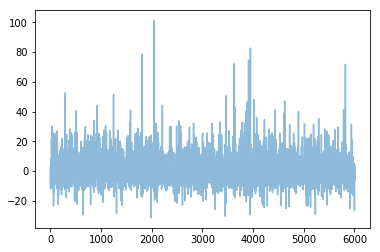

In [76]:
# plt.plot(metric['226_228']['preds'])
plt.plot(metric['226_228']['ytest'] - metric['226_228']['preds'],alpha=0.5)
